In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [9]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [10]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

In [11]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [6 x 2]

           Trtmt total
1          Blank     1
2   Ferrihydrite    18
3 Heavy Fraction     3
4      Kaolinite    13
5         Quartz    15
6           Soil    16


In [12]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Quartz","Ferrihydrite","Heavy Fraction","Kaolinite"))
variables

           Trtmt
1         Quartz
2   Ferrihydrite
3 Heavy Fraction
4      Kaolinite


In [15]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == c(2.5,3.0)) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == c(2.5,3.0)) & (sample_data(physeq)$Trtmt == "Soil")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>1500, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Soil")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq, cooksCutoff=TRUE)
# Change Cooks Cutoff to control outliers or not
    results$Trtmt = Trtmt
    results = data.frame(results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [16]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [17]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

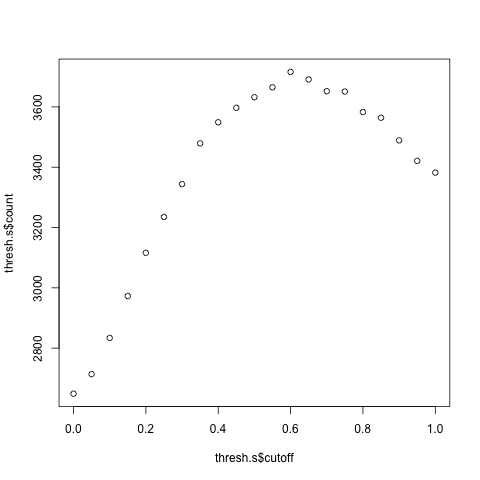

In [18]:
%%R
range = seq(0,1,0.05)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [19]:
%%R
group_by(DA, Trtmt) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=0.6) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fcCombMonths.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [3]:
%%R
l2fc<-read.csv("../../SeqData/l2fcCombMonths.csv")

In [4]:
%%R
dim(l2fc[is.na(l2fc$padj)==TRUE,])/(dim(l2fc[is.na(l2fc$padj)==FALSE,])+dim(l2fc[is.na(l2fc$padj)==TRUE,]))
# Fraction of OTUs that were designated as "outliers" 

[1] 0.03783615 0.50000000


In [5]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(Trtmt)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(Trtmt)%>%
    count(Trtmt,Sig)%>%
    group_by(Trtmt)%>%
    mutate(Fraction=n/sum(n))
mean(d$Fraction[d$Sig==1])

[1] 0.1863194


In [6]:
%%R
head(l2fc)

   Trtmt      OTU   baseMean      l2FC        SE       pvalue  Kingdom
1 Quartz  69_2370 59.5440236  4.651747 0.6734146 4.925667e-12 Bacteria
2 Quartz 67_26460  0.8162964 -2.052713 1.6220306 2.056849e-01 Bacteria
3 Quartz 96_50315  3.8392939  0.332505 0.9622914 7.296925e-01 Bacteria
4 Quartz 58_38953  1.8800536  3.473145 1.3833426 1.204953e-02 Bacteria
5 Quartz 73_37380  4.9772368  1.716102 1.8879580 3.633647e-01 Bacteria
6 Quartz 65_11911  0.9298593  1.005215 1.4208605 4.792751e-01 Bacteria
          Phylum                 Class             Order             Family
1  Fibrobacteres         Fibrobacteria           258ds10               <NA>
2  Fibrobacteres         Fibrobacteria           258ds10               <NA>
3  Fibrobacteres         Fibrobacteria           258ds10               <NA>
4  Fibrobacteres         Fibrobacteria           258ds10               <NA>
5 Proteobacteria Epsilonproteobacteria Campylobacterales Campylobacteraceae
6 Proteobacteria   Deltaproteobacteria Bdellovi

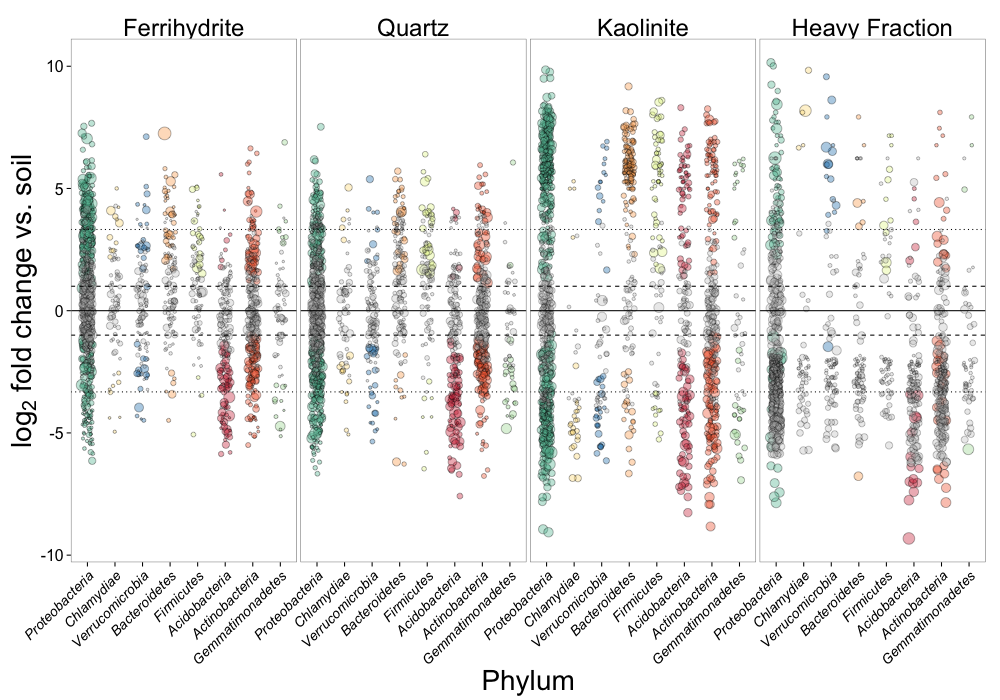

In [7]:
%%R -w 1000 -h 700
# setting the image sizes, then making the figure...

d = l2fc

d = group_by(d, Trtmt) %>%
    mutate(sig = ifelse(padj<0.1,1,0))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(pvalue != 'NA')
# This compares it to the whole sample, not just the signficantly increased subset in l2fc

N=50

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    
   
d = d %>%
    #filter(Month==2.5) %>%
    filter(Phylum=="Chlamydiae"|Phylum=="Proteobacteria"|Phylum=="Verrucomicrobia"|Phylum=="Bacteroidetes"|Phylum=="Gemmatimonadetes"|Phylum=="Firmicutes"|Phylum=="Actinobacteria"|Phylum=="Acidobacteria")
    
    
max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Phylum, y = l2FC, fill = Phylum, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Phylum, y = l2FC, fill = Phylum, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Phylum, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

    
#p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.
    
colourCount = 8
getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
p = p + scale_fill_manual(guide="none", values=c("grey",paste(getPalette(colourCount))))


#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [10]:
%%R
ggsave(filename="DiffAbund16SCombMonths.jpg", plot=p ,width=11.5, height=8)

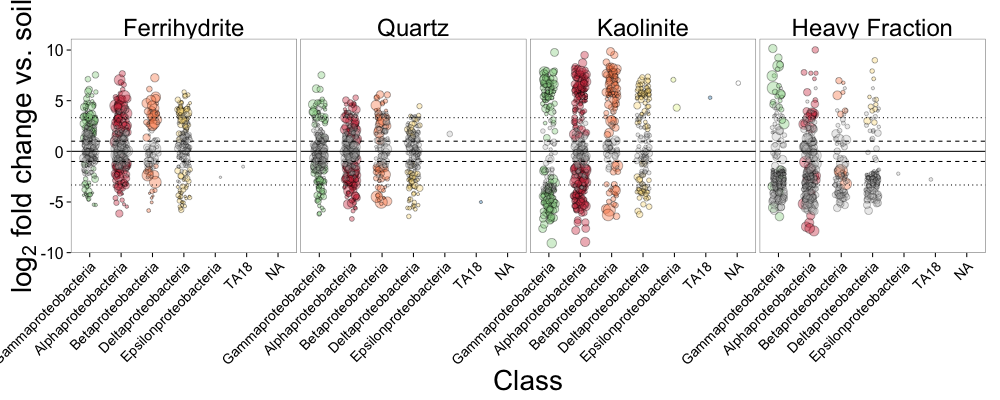

In [28]:
%%R -w 1000 -h 400
# setting the image sizes, then making the figure...

d = l2fc

d = group_by(d, Trtmt) %>%
    mutate(sig = ifelse(padj<0.1,1,0))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(pvalue != 'NA')%>%
    filter(Phylum=="Proteobacteria")
# This compares it to the whole sample, not just the signficantly increased subset in l2fc

  
max.l2FC = ddply(d, .(Class), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Class = factor(d$Class, max.l2FC[order(-max.l2FC$M),]$Class)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Class, y = l2FC, fill = Class, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~Trtmt)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Class, y = l2FC, fill = Class, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Class, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

    
#p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Class")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.
    
colourCount = length(levels(d$Class))
getPalette = colorRampPalette(brewer.pal(colourCount, "Spectral"))
p = p + scale_fill_manual(guide="none", values=c("grey",paste(getPalette(colourCount))))


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
p

In [9]:
%%R

cutoff=2
abund=0.005

d.high = l2fc %>%
    dplyr::filter(l2FC>cutoff, padj<=0.1)%>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::mutate(Tax=Family)%>%
    dplyr::group_by(Trtmt,Tax)%>%
    dplyr::summarise(totabund=sum(relabund))%>%
    dplyr::mutate(Tax=ifelse(totabund<=abund, "Other", ifelse(is.na(Tax), "Other", paste(Tax))))%>%
    dplyr::group_by(Trtmt,Tax)%>%
    dplyr::summarise(totabund=sum(totabund))

colnames(d.high) <- c("Trtmt","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.


mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
len = length(mean.Abund[order(-mean.Abund$M),]$Tax)
levs = c(mean.Abund[order(-mean.Abund$M),]$Tax[2:len],mean.Abund[order(-mean.Abund$M),]$Tax[1])
d.high$Tax = factor(d.high$Tax, levels=levs)

# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

levels(d.high$Tax)

 [1] "Xanthomonadaceae"      "Gaiellaceae"           "Rhizobiaceae"         
 [4] "Coxiellaceae"          "Comamonadaceae"        "Streptomycetaceae"    
 [7] "Chitinophagaceae"      "Rhodocyclaceae"        "Rhodospirillaceae"    
[10] "Phyllobacteriaceae"    "Sphingomonadaceae"     "[Chthoniobacteraceae]"
[13] "Isosphaeraceae"        "Pseudomonadaceae"      "Burkholderiaceae"     
[16] "Xenococcaceae"         "Bacillaceae"           "Microbacteriaceae"    
[19] "Oxalobacteraceae"      "Caulobacteraceae"      "Sinobacteraceae"      
[22] "Legionellaceae"        "Nocardioidaceae"       "Sporichthyaceae"      
[25] "Hyphomicrobiaceae"     "Paenibacillaceae"      "Chamaesiphonaceae"    
[28] "Saprospiraceae"        "Moraxellaceae"         "Rhodobacteraceae"     
[31] "Sphingobacteriaceae"   "Aeromonadaceae"        "Micrococcaceae"       
[34] "Conexibacteraceae"     "Frankiaceae"           "Patulibacteraceae"    
[37] "Bradyrhizobiaceae"     "Enterobacteriaceae"    "Alcaligenaceae"       

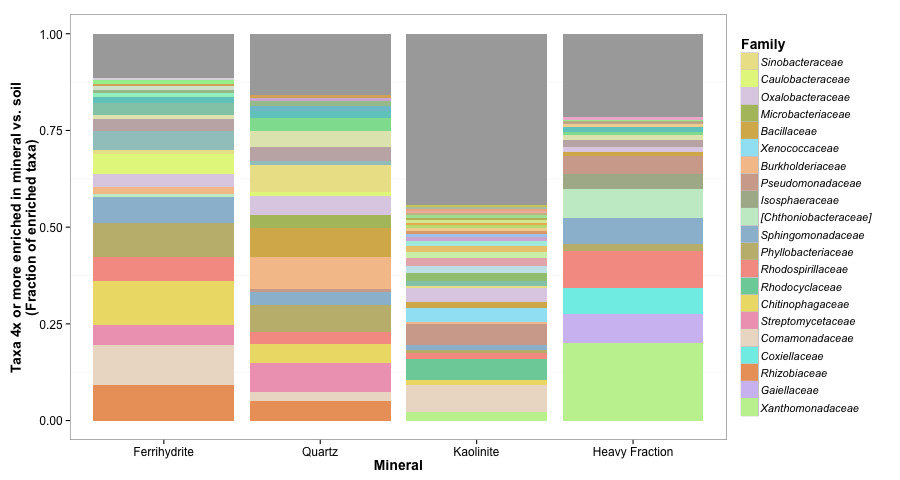

In [10]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
len = length(colors)
colors[len] = 'darkgrey'

p = ggplot(d.plot, aes(x=Trtmt,y=relabund,fill = Tax))

N=50
Breaks=factor(d.plot$Tax, d.plot[order(-d.plot$relabund),]$Tax)[1:N]

p = p + scale_fill_manual(values = colors, breaks=Breaks)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Family", ncol = 1, reverse=TRUE))

p = p + xlab("Mineral") + ylab("Taxa 4x or more enriched in mineral vs. soil\n(Fraction of enriched taxa)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11, face="italic"), legend.title=element_text(size=14), legend.position="right")
p = p + theme(strip.background = element_blank(),strip.text = element_text(size=14), panel.grid.major= element_blank())

p

In [11]:
%%R
ggsave(filename="DA16SFamilyCutoff2CombMonths.jpg", p, width=7.5, height=6.75)

Chitinophaga (Saprospirae) - gliding behaviour - decompose fungi???  
Janthinobacterium (Burkholderia) - soil bacteria - violacein - anti-fungal properties  
Rhizobiales  
Paenebacillus - N fixer - affinity for low iron... (high in quartz)  
Candidatus Xiphinematobacter (the Chthonibacter) may be nematode endosymbiont! Nematode carries into HF! Bag mesh 18µm, nematodes can be 5µm in diameter.  
Prosthecobacter - Verrucomicrobia, oligotroph,  
Coxiellaceae(21_4995, 65_477, 22_8148)  

In [ ]:
%%R
d.subset = l2fc %>%
    dplyr::filter(Family=="Bacillaceae")%>%
    dplyr::group_by()
d.subset[order(-d.subset$baseMean),]

In [221]:
%%R

d.high = l2fc %>%
    dplyr::filter(padj<=0.1)%>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus=="Bdellovibrio")%>%
    dplyr::select(Month,Trtmt,OTU,l2FC,Genus,Species,relabund,l2FC)
#    dplyr::summarise(l2FC)
d.high

Source: local data frame [41 x 7]
Groups: Trtmt, Month

   Month        Trtmt        OTU     l2FC        Genus       Species
1    2.5       Quartz    7_49588 4.106651 Bdellovibrio bacteriovorus
2    2.5       Quartz  39_124616 3.963450 Bdellovibrio            NA
3    2.5       Quartz   38_48229 3.762944 Bdellovibrio            NA
4    2.5       Quartz    7_18640 4.108368 Bdellovibrio            NA
5    2.5       Quartz    39_2737 3.982782 Bdellovibrio            NA
6    2.5       Quartz   104_3722 3.201130 Bdellovibrio            NA
7    2.5 Ferrihydrite   21_18795 2.405182 Bdellovibrio            NA
8    2.5 Ferrihydrite    89_7097 4.851354 Bdellovibrio            NA
9    2.5 Ferrihydrite 72.2_54133 2.826656 Bdellovibrio            NA
10   2.5 Ferrihydrite    7_49588 4.774415 Bdellovibrio bacteriovorus
..   ...          ...        ...      ...          ...           ...
Variables not shown: relabund (dbl)


In [33]:
%%R
tax_table(subset_taxa(physeq,Family=="Comamonadaceae"))

Taxonomy Table:     [40 taxa by 7 taxonomic ranks]:
             Kingdom    Phylum           Class                Order            
37_380142    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
42_663375    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
10_106228    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
10_1692539   "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
75.2_876477  "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
59_1081      "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
3_1277       "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
3_1322241    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
10_372487    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
79_582324    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkholderiales"
10_814597    "Bacteria" "Proteobacteria" "Betaproteobacteria" "Burkh

In [30]:
%%R

cutoff = 3.3

d.OTU = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff, padj<=0.1)%>%
# Include only the rows where log2fold change is higher than 3.
    dplyr::group_by(Trtmt,Month) %>%
# Then, treating each month and mineral separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean))

#colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.OTU, .(OTU), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.OTU$OTU = factor(d.OTU$OTU, levels=mean.Abund[order(-mean.Abund$M),]$OTU)
# Order the phyla by abundance
d.OTU<-d.OTU[with(d.OTU, order(OTU)),]
# Sort the whole dataframe by this order

In [31]:
%%R
cutoff=0.02
d.OTU.common<-d.OTU %>%
    dplyr::filter(relabund>cutoff)
d.OTU.common$relabund
dim(d.OTU.common)

[1] 61 16


Best hit for 28_165 was Chitinophaga ginsengisegetis strain Gsoil 040 (99% ID), does not degrade chitin  
For 46_32212 was Chitinophaga oryziterrae strain YC7001 (99% ID), does degrade chitin  
For 49_597909, was Chitinophaga arvensicola strain NBRC 14973, also niastenis and ginsengisegetis (all 99% ID)  
For 80_9723 - Rhizobium  
For 71_10279 - Pseudomonas ... (big in H minerals)  
For 91_16995 - Rhizobacter (big in F,2)  
Coxiellaceae:  
For 21_4995 - Pseudomonas, Legionella only 91%  
For 65_477 - Thalassotalea Profundimonas Alcanivorax Methylococcus, only 91%  
For 22_8148 - Coxiella, Pseudomonas, only 91%  

Maybe there are small differences between these OTUs and sequences that are ecologically relevant > use Oligotyping to separate?  


In [33]:
#Who is 
!grep -A 1 23_474 ../../SeqData/otus.pick.fasta

>23_474
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCAAAACTGACGAGCTAGAGTATGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAG


In [22]:
%%R
Trtmt = c("A","A","A","A","A","A","B","B","B","B","B","B")
Month = c(1,1,1,2,2,2,1,1,1,2,2,2)
baseMean = c(3,2,1,3,2,3,1,2,4,2,3,1)
Phylum = c("Phylum1","Phylum1","Phylum2","Phylum1","Phylum2","Phylum2")
h=data.frame(Trtmt,Month,baseMean,Phylum)
# Testing to make sure I am calculating the relative abundances correctly (yes).
h

   Trtmt Month baseMean  Phylum
1      A     1        3 Phylum1
2      A     1        2 Phylum1
3      A     1        1 Phylum2
4      A     2        3 Phylum1
5      A     2        2 Phylum2
6      A     2        3 Phylum2
7      B     1        1 Phylum1
8      B     1        2 Phylum1
9      B     1        4 Phylum2
10     B     2        2 Phylum1
11     B     2        3 Phylum2
12     B     2        1 Phylum2


In [23]:
%%R
h.relabund = h %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::group_by(Trtmt,Month,Phylum) %>%
# Then, using this data, still grouped by month, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
    
h.relabund

Source: local data frame [8 x 4]
Groups: Trtmt, Month

  Trtmt Month  Phylum  relabund
1     A     1 Phylum1 0.8333333
2     A     1 Phylum2 0.1666667
3     A     2 Phylum1 0.3750000
4     A     2 Phylum2 0.6250000
5     B     1 Phylum1 0.4285714
6     B     1 Phylum2 0.5714286
7     B     2 Phylum1 0.3333333
8     B     2 Phylum2 0.6666667


In [1]:
!head -50 ../../SeqData/otus.pick.fasta

>28_165
GTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGACATGTAAGTCCGTGGTGAAATCTCCGAGCTTAACTCGGAAACTGCCATGGATACTATATGTCTTGAATGTTGTGGAGGTTAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCAATTGCGAAGGCAGCTGGCTACACAAATATTGACGCTGAGGCACGAAAGCGTGGGGATCAAACAGGATTAGAAACCCCAGTAGTCC
>13_1570
GTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTTGTTAAGACCGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTGGTGACTGGCAAGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGAAACCCCAGTAGTCC
>28_3449
GTGCCAGCAGCCGCGGTAATACGTAGGGCGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGCTTGTCACGTCGGGTGTGAAAGCCCGGGGCTTAACCCCGGGTCTGCATTCGATACGGGCTAGCTAGAGTGTGGTAGGGGAGATCGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGATCTCTGGGCCATTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGGATTAGAAACCCCAGTAGTCC
>56_4302
GTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGATTGTTAAGTTA

###Plotting Quartz vs Ferrihydrite

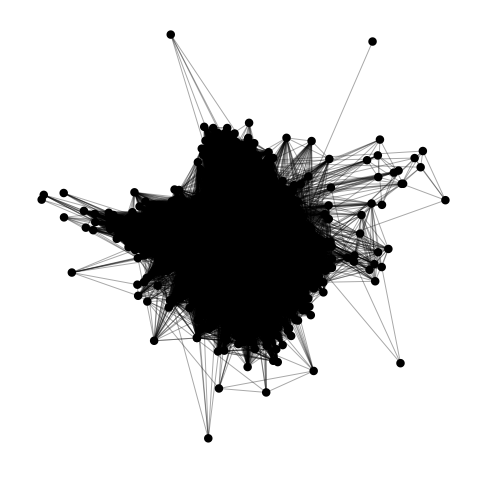

In [308]:
%%R
ig = make_network(physeq, dist.fun="bray", type="taxa",  max.dist=0.9, keep.isolates=FALSE)
p = plot_network(ig, physeq, line_weight=0.4, label=NULL)
p

###Making pos/neg figures

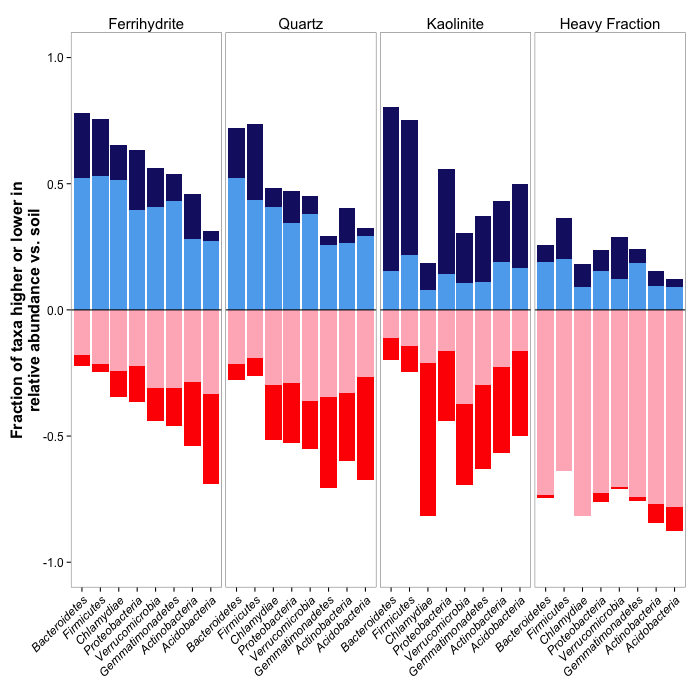

In [55]:
%%R -h 700 -w 700

FDR=0.1

d = l2fc
PhylumOrder <- c("Bacteroidetes","Firmicutes","Chlamydiae","Proteobacteria","Verrucomicrobia","Gemmatimonadetes","Actinobacteria","Acidobacteria")
d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))

d = d %>%
    filter(Phylum %in% PhylumOrder)%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse((padj <= FDR),1,0))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,Signif))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(Phylum,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Sum = sum(n)) %>%
    mutate(Shade = log(Sum))%>%
    arrange(Phylum)

d.pos = subset(d,Resp>0)
d.neg = subset(d,Resp<0)
d.pos$Phylum <- factor(d.pos$Phylum, levels = PhylumOrder, ordered=TRUE)
d.neg$Phylum <- factor(d.neg$Phylum, levels = PhylumOrder, ordered=TRUE)

p = ggplot()
#p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack") 
#p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack")
p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif),stat="identity", position="stack") 
p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif),stat="identity", position="stack")
p = p + scale_x_discrete(limits=PhylumOrder)
p = p + facet_grid(~Trtmt)
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(size = 12, angle=45, hjust=1, face="italic"))
p = p + theme(axis.text.y = element_text(size = 12))
p = p + scale_fill_manual(values=c("lightpink","red","steelblue2","midnightblue"))
#p = p + scale_alpha_continuous(range=c(0.3, 1),guide=F)
p = p + ylab("Fraction of taxa higher or lower in\nrelative abundance vs. soil") + xlab("")
p = p + ylim(c(-1,1))
p = p + theme(strip.text = element_text(size = 15),
              axis.title.y = element_text(size = 16, face = "bold"),
              legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
p = p + geom_hline(y = 0.0, linetype=1)

p

In [6]:
%%R
ggsave(filename="DA16SredblueCombMonths.jpg", plot=p ,width=9, height=6)

In [67]:
%%R

TotalOTUs = length(unique(l2fc$OTU))

dsum = l2fc %>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse((padj <= FDR),1,0))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,Signif))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,-1,
                               ifelse(Resp==1&Signif==1,1,
                                      ifelse(Resp==-1&Signif==0,0,
                                             ifelse(Resp==1&Signif==0,0,"")))))%>%
    group_by(OTU,RespSignif)%>%
    summarize()%>%
    group_by(RespSignif)%>%
    summarize(Total=n())%>%
    mutate(Fraction = Total/TotalOTUs)
dsum

Source: local data frame [3 x 3]

  RespSignif Total  Fraction
1         -1  1030 0.2682292
2          0  2891 0.7528646
3          1  1506 0.3921875


##Swarming microbes?

In [53]:
%%R
Swarmers = c("Bacillus", "Clostridium", "Azospirillum", "Rhodospirillum", "Escherichia",
             "Salmonella", "Serratia", "Yersinia", "Proteus", "Vibrio","Aeromonas","Pseudomonas")

In [54]:
%%R

d.swarm = l2fc %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus %in% Swarmers)%>%
    dplyr::select(Trtmt,OTU,l2FC,Phylum,Class,Genus,Species,relabund,l2FC,padj)
# This gives us a list of all the possible swarmer cells, based on their genus.
# If their l2FC is consistently positive, this might support the idea that swarming helps colonization

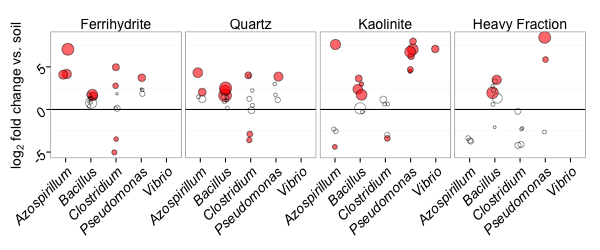

In [55]:
%%R -w 600 -h 250

#d = d.swarm[d.swarm$Month==2.5,]
d = d.swarm

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Genus, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Genus, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
#p = p + scale_fill_manual(values=c("gold","orange","red","darkgrey"))
p = p + scale_fill_manual(values=c("red","darkgrey"),guide="none")
p = p + facet_grid(~Trtmt)
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text = element_text(angle=45,hjust=1, size=14, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=14),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=14),
             panel.grid.major = element_blank())
p

In [56]:
%%R
ggsave(filename="SwarmersCombMonths.jpg", plot=p ,width=8, height=4)

## Predatory microbes?

In [39]:
%%R
Preds = c("Myxococcus","Bdellovibrio","Lysobacter","Vampirovibrio","Vampirococcus","Daptobacter",
         "Cytophaga","Aristabacter","Chitinophaga","Ensifer","Micavibrio","Cupriavidus","Stenotrophomonas",
         "Myxobacteria","Herpetosiphon","Streptoverticillum","Agromyces")
PredFams = c("Bacteriovoracaceae","Bdellovibrionaceae","Cytophagaceae")

In [40]:
%%R

d.pred = l2fc %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus %in% Preds | Family %in% PredFams)%>%
    dplyr::select(Trtmt,OTU,l2FC,Phylum,Family,Genus,Species,relabund,l2FC,padj)
# This gives us a list of all the possible swarmer cells, based on their genus.
# If their l2FC is consistently positive, this might support the idea that swarming helps colonization

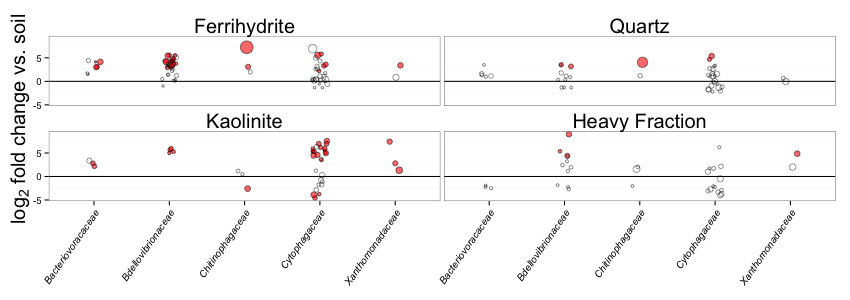

In [47]:
%%R -w 850 -h 300

d = d.pred

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Family, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Family, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
p = p + scale_fill_manual(values=c("red","darkgrey"),guide="none")
p = p + facet_wrap(~Trtmt, ncol=2)
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text.x = element_text(angle=55,hjust=1, size=10, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=20),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=20),
             panel.grid.major = element_blank())
p

In [48]:
%%R
ggsave(filename="PredatorsCombMonths.jpg", plot=p ,width=6, height=6)

###What about Fe bacteria?

In [49]:
%%R
Fe = c("Shewanella","Geobacter","Ferribacterium","Thiobacillus","Rhodovulum","Rhodobacter","Rhodomicrobium",
       "Rhodopseudomonas","Gallionella","Sideroxydans","Ferrovum","Ferritrophicum","Leptothrix",
      "Acidithiobacillus","Thiodictyon","Acidiferrobacter","Mariprofundis","Thermomonas","Acidovorax","Aquabacterium",
      "Pseudogulbenklania","Azospira","Paracoccus","Pseudogulbenkiania","Sphaerotilus","Marinobacter","Acidimicrobium",
      "Ferrimicrobium","Ferrithrix","Alicyclobacillus","Chlorobium","Leptospirillum","Aquifex","Ferroplasma",
      "Acidiplasma","Ferroglobus","Sulofolobus","Acidianus","Metallosphaera","Desulfobivrio","Thermus",
       "Thermoterrabacterium","Desulfotomaculum","Geothrix","Ferrimonas","Acidiphilum",
      "Sulfurospirillum","Deferribacter","Thermodesulfobacterium","Thermotoga","Sulfolobus","Pyrococcus",
       "Archaeoglobus","Methanococcus","Desulfuromusa","Pelobacter","Desulfuromonas","Desulfomonile","Geospirillum")
# Could include Bacillus and Clostridium, but perhaps too general

In [50]:
%%R

d.Fe = l2fc %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus %in% Fe)%>%
    dplyr::select(Trtmt,OTU,l2FC,Phylum,Family,Genus,Species,relabund,l2FC,padj)
# This gives us a list of all the possible swarmer cells, based on their genus.
# If their l2FC is consistently positive, this might support the idea that swarming helps colonization

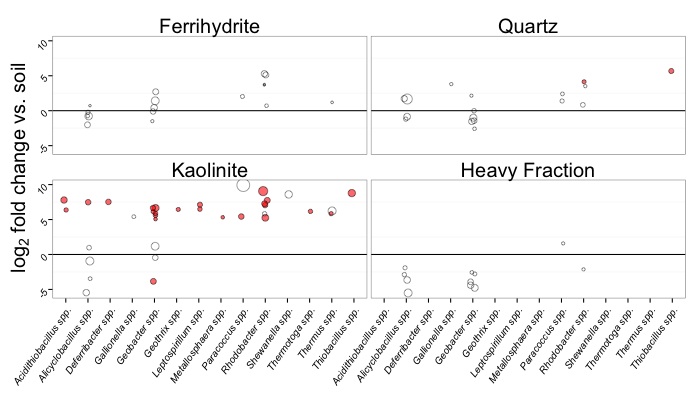

In [51]:
%%R -w 700 -h 400

d = d.Fe

d = d %>%
    mutate(Species = paste(Genus,"spp."))

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Species, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Species, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
#p = p + scale_fill_manual(values=c("gold","orange","red","darkgrey"))
p = p + scale_fill_manual(values=c("red","darkgrey"), guide="none")
p = p + facet_wrap(~Trtmt, ncol=2)
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text = element_text(angle=55,hjust=1, size=10, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=20),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=20),
             panel.grid.major = element_blank())
p

In [52]:
%%R
ggsave(filename="FeDACombMonths.jpg", plot=p ,width=6, height=6)

That big Kaonlinite OTU is Paracoccus marcusii (3% of total abundance); can't use NO3 as e- acceptor
  
Similarity of transporters? What they eat...


### What about N?

In [57]:
%%R
Nfix = c("Bradyrhizobium","Azospirillum","Gluconacetobacter","Mesorhizobium","Rhodobacter","Rhodospirillum","Rhizobium",
"Sinorhizobium","Beijerinckia","Methylocella","Methylosinus","Methylocystis","Rhizobium","Xanthobacter","Burkholderia",
"Herbaspirillum","Azoarcus","Alcaligenes","Arcobacter","Acidothiobacillus","Klebsiella","Vibrio","Marichromatium",
"Methylomonas","Azotobacter","Klebsiella",'Methylobacter','Azomonas',"Azotobacter","Pseudomonas","Anabaena",'Chlorogloeopsis',
'Calothrix','Cyanothece',"Dermacarpa","Fischerella","Gloeothece","Lyngbya","Myxosarcina","Nostoc","Oscillatoria",
"Phormidium","Plectonema","Pseudanabaena",'Scytonema','Symploca','Synechococcus','Synechocystis','Tolypothrix',
'Trichodesmium','Xenococcus','Frankia','Paenibacillus','Rhodobacter','Desulfobacter','Azotobacter','Paenibacillus',
'Clostridium','Treponema','Methanobrevibacter','Methanococcus','Methanothermobacter','Desulfobacter','Desulfomicrobium',
'Desulfotomaculum','Desulfonema','Desulfovibrio','Clostridium','Acetobacterium','Desulfosporosinus','Treponema',
'Spirochaeta','Chlorobium','Pelodictyon','Methanobrevibacter','Methanocaldococcus','Methanococcus','Methanopyrus',
'Methanothermobacter','Methanosarcina')

In [60]:
%%R

d.Nfix = l2fc %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::filter(Genus %in% Nfix)%>%
    dplyr::select(Trtmt,OTU,l2FC,Phylum,Family,Genus,Species,relabund,l2FC,padj)
# This gives us a list of all the possible swarmer cells, based on their genus.
# If their l2FC is consistently positive, this might support the idea that swarming helps colonization

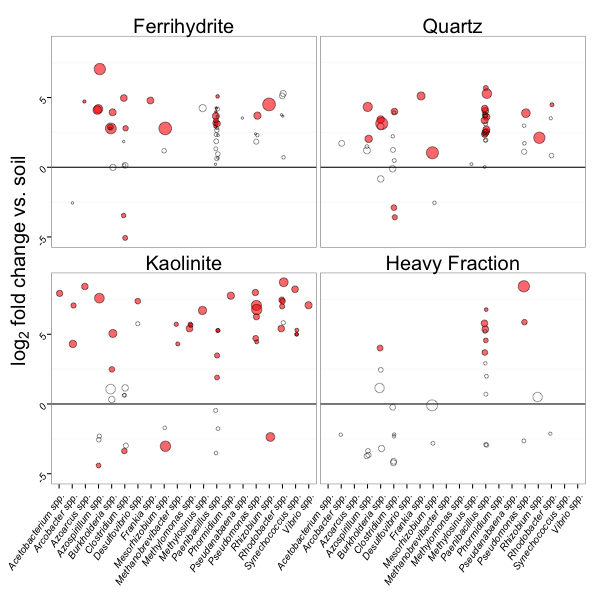

In [61]:
%%R -w 600 -h 600

d = d.Nfix

d = d %>%
    mutate(Species = paste(Genus,"spp."))

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.yes, aes(x = Species, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.no, aes(x = Species, y = l2FC, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
p = p + scale_fill_manual(values=c("red","darkgrey"), guide="none")
p = p + facet_wrap(~Trtmt,ncol=2)
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text = element_text(angle=55,hjust=1, size=10, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=20),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=20),
             panel.grid.major = element_blank())
p

In [62]:
%%R
ggsave(filename="NfixCombMonths.jpg", plot=p ,width=6, height=6)

###What about mineral-specific responses?

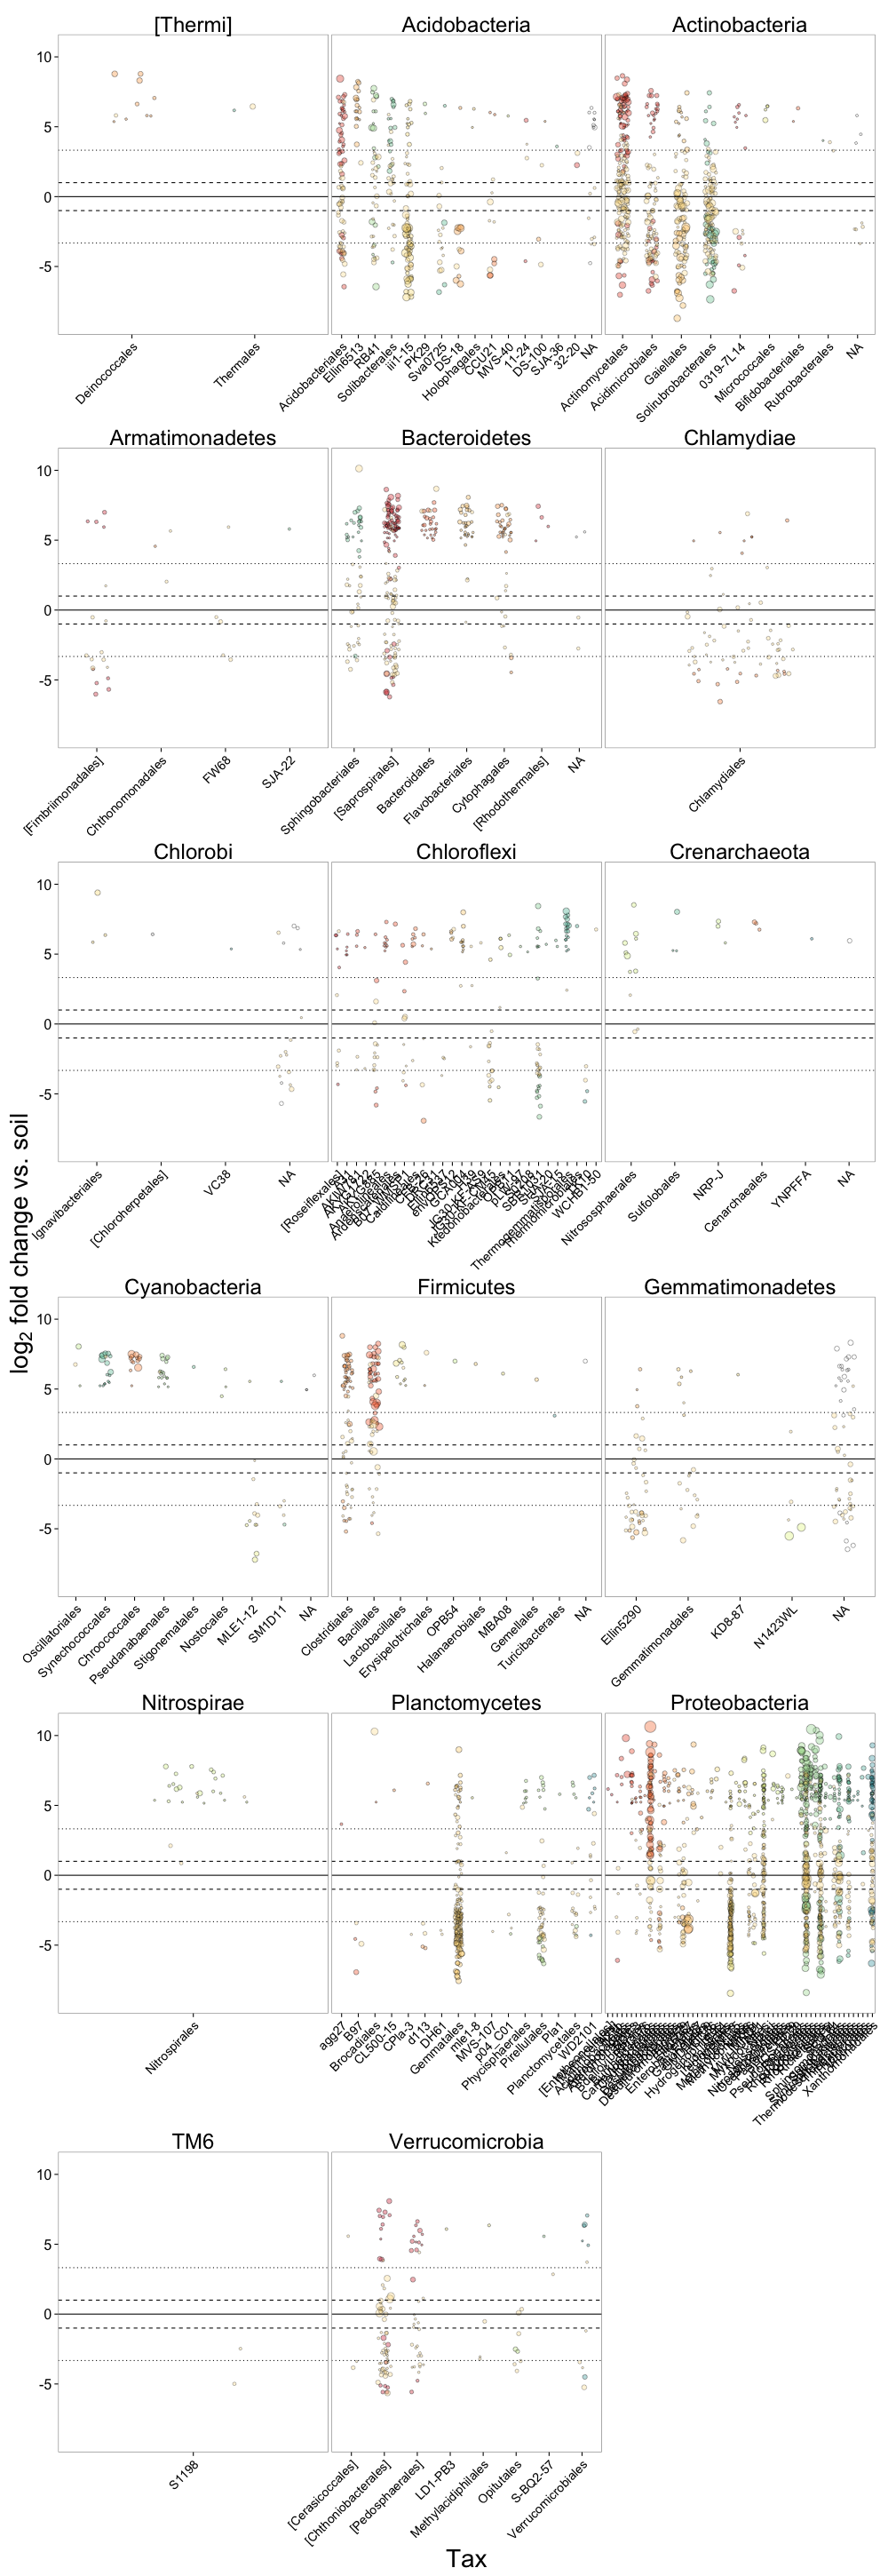

In [140]:
%%R -w 1000 -h 2900
# setting the image sizes, then making the figure...

d = l2fc

d = group_by(d, Trtmt, Month) %>%
    mutate(sig = ifelse(padj<=0.1,1,0))%>%
    mutate(sig = ifelse(is.na(padj),0,sig))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(Trtmt=="Kaolinite")%>%
    mutate(Tax=Order)
# This compares it to the whole sample, not just the signficantly increased subset in l2fc

N=10

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    
   
d$MonthName = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

#d = d %>%
    #filter(Month==2.5) %>%
    #filter(Phylum=="Chlamydiae"|Phylum=="Proteobacteria"|Phylum=="Verrucomicrobia"|Phylum=="Bacteroidetes"|Phylum=="Gemmatimonadetes"|Phylum=="Firmicutes"|Phylum=="Actinobacteria"|Phylum=="Acidobacteria")
    
    
max.l2FC = ddply(d, .(Tax), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Tax = factor(d$Tax, max.l2FC[order(-max.l2FC$M),]$Tax)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Tax, y = l2FC, fill = Tax, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_wrap(~Phylum, scales="free_x", ncol=3)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Tax, y = l2FC, fill = Tax, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Tax, y = l2FC, fill = c("grey"), size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

    
#p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Tax")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

colourCount = length(levels(d$Tax))+1
getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
Values = getPalette(colourCount)
Values[1] = "grey"
p = p + scale_fill_manual(guide="none", values=Values)

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
p

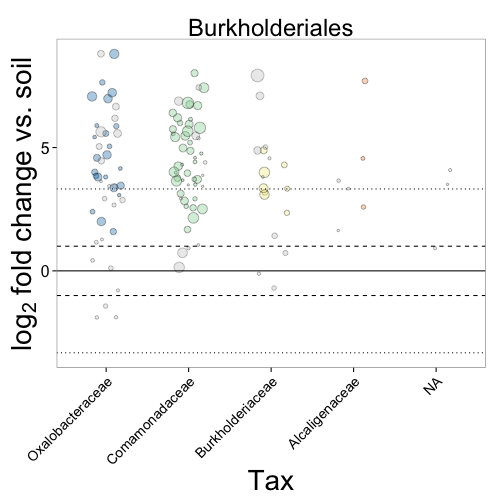

In [167]:
%%R -w 500 -h 500
# setting the image sizes, then making the figure...

d = l2fc

d = group_by(d, Trtmt, Month) %>%
    mutate(sig = ifelse(padj<=0.1,1,0))%>%
    mutate(sig = ifelse(is.na(padj),0,sig))%>%
    mutate(relabund=baseMean/Total)%>%
    filter(Trtmt=="Ferrihydrite")%>%
    filter(Phylum=="Proteobacteria")%>%
    filter(Class=="Betaproteobacteria")%>%
    filter(Order=="Burkholderiales")%>%
    mutate(Tax=Family)
# This compares it to the whole sample, not just the signficantly increased subset in l2fc

N=10

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    
   
d$MonthName = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

#d = d %>%
    #filter(Month==2.5) %>%
    #filter(Phylum=="Chlamydiae"|Phylum=="Proteobacteria"|Phylum=="Verrucomicrobia"|Phylum=="Bacteroidetes"|Phylum=="Gemmatimonadetes"|Phylum=="Firmicutes"|Phylum=="Actinobacteria"|Phylum=="Acidobacteria")
    
    
max.l2FC = ddply(d, .(Tax), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Tax = factor(d$Tax, max.l2FC[order(-max.l2FC$M),]$Tax)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Tax, y = l2FC, fill = Tax, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_wrap(~Order, scales="free_x", ncol=3)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = p + geom_point(data=d.yes, aes(x = Tax, y = l2FC, fill = Tax, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.no, aes(x = Tax, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))

    
#p = p + geom_point(shape = 21, alpha=0.45, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Tax")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

colourCount = length(levels(d$Tax))+1
getPalette = colorRampPalette(brewer.pal(8, "Spectral"))
Values = getPalette(colourCount)
Values[1] = "grey"
p = p + scale_fill_manual(guide="none", values=Values)

#p = p + scale_color_continuous(trans="log")    
#p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
p